# Downloading Dataset

In [ ]:
# !wget http://www.vision.caltech.edu/Image_Datasets/faces/faces.tar

In [ ]:
# !mkdir faces
# !tar -xvf faces.tar -C ./faces

In [ ]:
from PIL import Image
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
from sklearn import manifold


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
mat = scipy.io.loadmat('./faces/ImageData.mat')['SubDir_Data'].T
mat.shape

(450, 8)

# EDA

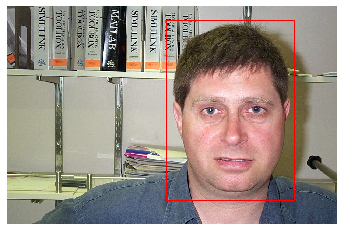

In [ ]:
fig, ax = plt.subplots(1)
img = Image.open(r"./faces/image_0001.jpg") 
ax.imshow(img)
xl, yb, xr, yt = mat[0][0], mat[0][1],mat[0][4], mat[0][5]
w, h = xr - xl, yt - yb
rect = patches.Rectangle((xl, yb), w, h, fill = False, edgecolor = 'r')
ax.add_patch(rect)
plt.axis('off')
plt.show()

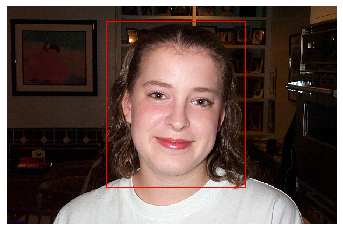

In [ ]:
fig, ax = plt.subplots(1)
img = Image.open(r"./faces/image_0365.jpg") 
ax.imshow(img)
xl, yb, xr, yt = mat[364][0], mat[364][1],mat[364][4], mat[364][5]
w, h = xr - xl, yt - yb
rect = patches.Rectangle((xl, yb), w, h, fill = False, edgecolor = 'r')
ax.add_patch(rect)
plt.axis('off')
plt.show()

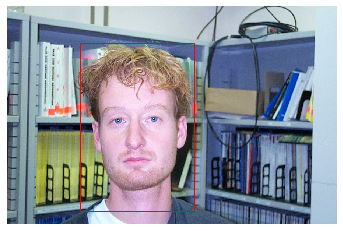

In [ ]:
fig, ax = plt.subplots(1)
img = Image.open(r"./faces/image_0257.jpg") 
ax.imshow(img)
xl, yb, xr, yt = mat[256][0], mat[256][1],mat[256][4], mat[256][5]
w, h = xr - xl, yt - yb
rect = patches.Rectangle((xl, yb), w, h, fill = False, edgecolor = 'r')
ax.add_patch(rect)
plt.axis('off')
plt.show()

# Foreground Background Segmentation

In [ ]:
import glob
g = glob.glob("./faces/*.jpg")
g.sort()
image_list = []
for n in range(len(g)):
    img = Image.open(g[n]).convert('RGB')
    img = img.resize((224,224))
    image_list.append(img)


In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize( mean = np.array([0.485, 0.456, 0.406]),
    std = np.array([0.229, 0.224, 0.225]))])

In [ ]:
class Faces(Dataset):
    def __init__(self, g, mat, transform=None):
        super().__init__()
        self.g = g
        self.mat = mat
        self.transform = transform
    
    def __len__(self):
        return len(self.g)
    
    def __getitem__(self,item):
        img = Image.open(self.g[item]).convert('RGB')
        
        bbox = torch.from_numpy(self.mat[item].astype('int32'))
        
        if self.transform is not None:
            img = self.transform(img)
        
        img_crop = torch.nn.functional.interpolate(img[:, bbox[5]:bbox[0], bbox[0]:bbox[4]].unsqueeze(0), (256, 256)).squeeze()
        img = torch.nn.functional.interpolate(img.unsqueeze(0),(256,256)).squeeze()
        return {'image' : img, 'bbox' : bbox, 'crop' : img_crop}

In [ ]:
data = Faces(g, mat, transform)
len(data)
batch_size = 1

In [ ]:
# model_seg = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()
model_seg= torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
model_seg.to(device).eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /home/nivedita.rufus/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /home/nivedita.rufus/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
data_loader = torch.utils.data.DataLoader(data,batch_size=batch_size,shuffle=False)

In [ ]:
image_seg=[]
for i,batch in enumerate(data_loader):
    print("Batch: ", i)
    img = batch['image'].to(device)
    out = model_seg(img)['out'][0]
    out = out.argmax(0)
    image_seg.append(out.cpu().numpy())


Batch:  0
Batch:  1
Batch:  2
Batch:  3
Batch:  4
Batch:  5
Batch:  6
Batch:  7
Batch:  8
Batch:  9
Batch:  10
Batch:  11
Batch:  12
Batch:  13
Batch:  14
Batch:  15
Batch:  16
Batch:  17
Batch:  18
Batch:  19
Batch:  20
Batch:  21
Batch:  22
Batch:  23
Batch:  24
Batch:  25
Batch:  26
Batch:  27
Batch:  28
Batch:  29
Batch:  30
Batch:  31
Batch:  32
Batch:  33
Batch:  34
Batch:  35
Batch:  36
Batch:  37
Batch:  38
Batch:  39
Batch:  40
Batch:  41
Batch:  42
Batch:  43
Batch:  44
Batch:  45
Batch:  46
Batch:  47
Batch:  48
Batch:  49
Batch:  50
Batch:  51
Batch:  52
Batch:  53
Batch:  54
Batch:  55
Batch:  56
Batch:  57
Batch:  58
Batch:  59
Batch:  60
Batch:  61
Batch:  62
Batch:  63
Batch:  64
Batch:  65
Batch:  66
Batch:  67
Batch:  68
Batch:  69
Batch:  70
Batch:  71
Batch:  72
Batch:  73
Batch:  74
Batch:  75
Batch:  76
Batch:  77
Batch:  78
Batch:  79
Batch:  80
Batch:  81
Batch:  82
Batch:  83
Batch:  84
Batch:  85
Batch:  86
Batch:  87
Batch:  88
Batch:  89
Batch:  90
Batch:  9

In [ ]:

def decode_segmap(image, nc=21):
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l

    if(l==15):
      r[idx] = 0
      g[idx] = 255
      b[idx] = 0
    else:
      r[idx] = 0
      g[idx] = 0
      b[idx] = 0
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [ ]:
import random
idxs = random.sample(range(0, 450), 16)

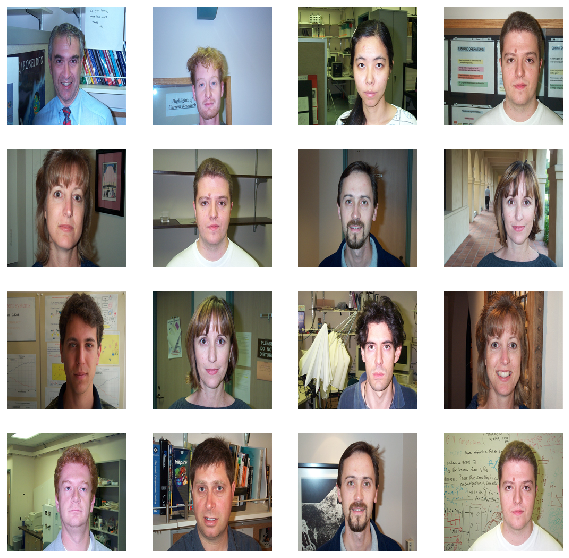

In [ ]:

plt.figure(figsize=(10,10))
for i,n in enumerate(idxs):
  plt.subplot(4,4,i+1)
  plt.axis('off')
  plt.imshow(image_list[n])

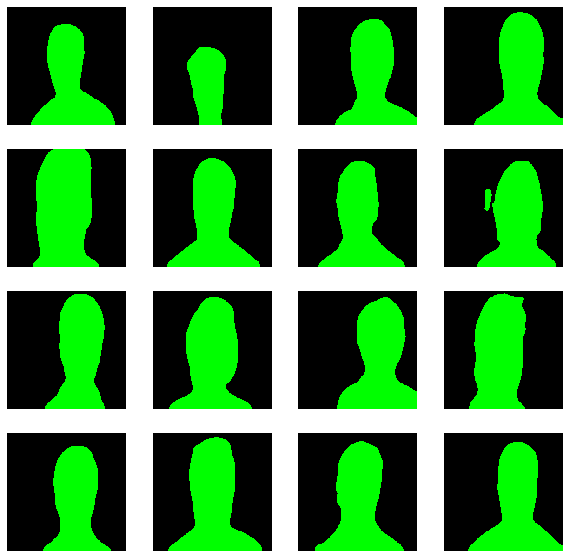

In [ ]:

plt.figure(figsize=(10,10))
for i,n in enumerate(idxs):
  plt.subplot(4,4,i+1)
  plt.axis('off')
  rgb = decode_segmap(image_seg[n])
  plt.imshow(rgb)